In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

Set *Axlmutants_Erl_F154* or *Axlmutants_Erl* to **True** in order to use these data.

In [3]:
ABC = preprocessing(Axlmuts_ErlF154=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

header = ABC.columns
treatments = ABC.columns[7:]

data = ABC.iloc[:, 7:].T
info = ABC.iloc[:, :7]

### Phenotypes

#### Cell Viability (from luminex...):

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv')
# Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv').T

Y_cv = Y_cv.iloc[:, 0:10].div(Y_cv.iloc[:, 0], axis=0).T

# Y_cv = Y_cv.iloc[:, 0:10].sub(Y_cv.iloc[:, 0:10].mean(axis=1), axis=0).T

# Chained MS mixed clustering + PLSR analysis

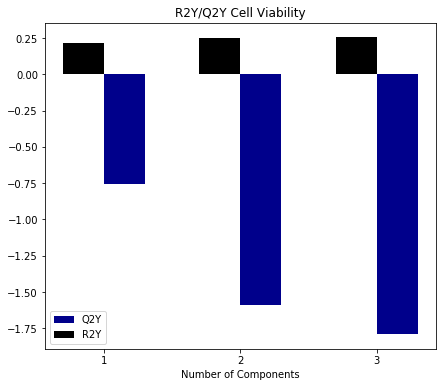

In [5]:
distance_method = "Binomial"
ncl = 3
GMMweight = 0

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

In [6]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv)

In [7]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data, Y_cv)

In [8]:
# fig, ax = plt.subplots(1,1,figsize=(6,5))
# plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

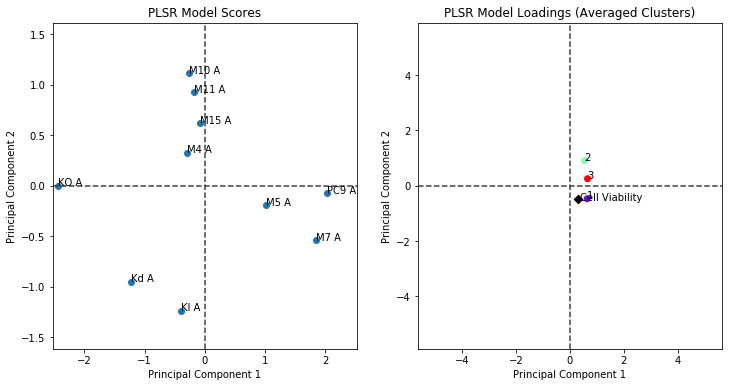

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, Y_cv, ncl, treatments)

In [10]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers.iloc[:10, :]

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,...,Pos_C2,r2/Std_C2,BioReps_C2,Prot_C3,abbv_C3,seqs_C3,UniprotAcc_C3,Pos_C3,r2/Std_C3,BioReps_C3
0,Annexin A2,Y317-p,GKsLYyYIQQD,P07355,ANXA2,1,N/A,Activated CDC42 kinase 1,Y518-p,VKKPTyDPVSE,...,TNK2,1,N/A,40S ribosomal protein SA,Y139-p,LTEASyVNLPT,P08865,RPSA,1,N/A
1,Catenin delta-1,Y228-p,GGSDNyGSLSR,O60716,CTNND1,1,N/A,Afadin,Y1230-p,TYTREyFTFPA,...,AFDN,1,N/A,60S ribosomal protein L10a,Y11-p,SRDTLyEAVRE,P62906,RPL10A,1,N/A
2,Crk-like protein,Y251-p,RVPCAyDKTAL,P46109,CRKL,1,N/A,Alpha-actinin-1,Y215-p,DVAEKyLDIPK,...,ACTN1,1,N/A,Abl interactor 2,Y213-p,VVPNDyVPSPT,Q9NYB9,ABI2,1,N/A
3,Cyclin-dependent kinase 1,Y15-p,IGEGTyGVVYK,P06493,CDK1,2,0.99,Annexin A1,Y207-p,DARALyEAGER,...,ANXA1,1,N/A,Annexin A2,Y238-p,KsYSPyDMLES,P07355,ANXA2,2,0.85
4,Cyclin-dependent kinase 2,Y15-p,IGEGtyGVVYK,P24941,CDK2,1,N/A,"Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 1",Y231-p,FDDSDyDEVPE,...,ARAP1,1,N/A,Catenin delta-1,Y257-p,SRQDVyGPQPQ,O60716,CTNND1,1,N/A
5,Desmoplakin,Y95-p,QPELKyGDGIQ,P15924,DSP,1,N/A,BAG family molecular chaperone regulator 3,Y240-p,AQQGEyQTHQP,...,BAG3,1,N/A,Cell surface glycoprotein MUC18,Y641-p,DQGEKyIDLRH,P43121,MCAM,1,N/A
6,Enhancer of filamentation 1,Y631-p,MDDYDyVHLQG,Q14511,NEDD9,1,N/A,Band 4.1-like protein 1,Y343-p,IRPGEyEQFES,...,EPB41L1,1,N/A,Clathrin heavy chain 1,Y1477-p,ITEEDyQALRT,Q00610,CLTC,1,N/A
7,Epidermal growth factor receptor kinase substrate 8,Y602-p,RADPPyTHTIQ,Q12929,EPS8,1,N/A,Band 4.1-like protein 2,Y623-p,EGDNIyVRHSN,...,EPB41L2,2,0.68,Cyclin-dependent kinase-like 5,Y171-p,ANYTEyVATRW,O76039,CDKL5,1,N/A
8,Filamin-B,Y904-p,IDNYDySHTVK,O75369,FLNB,1,N/A,Brain-specific angiogenesis inhibitor 1-associated protein 2-like protein 1,Y274-p,VVRKDyDTLSK,...,BAIAP2L1,1,N/A,Cysteine-rich protein 1,Y12-p,CNKEVyFAERV,P50238,CRIP1,1,N/A
9,Heat shock protein HSP 90-beta,Y596-p,IVTSTyGWTAN,P08238,HSP90AB1,1,N/A,Breast cancer anti-estrogen resistance protein 1,Y362-p,PAEDVyDVPPP,...,BCAR1,1,N/A,Dual adapter for phosphotyrosine and 3-phosphotyrosine and 3-phosphoinositide,Y139-p,EEPSIyESVRV,Q9UN19,DAPP1,1,N/A


In [11]:
create_download_link(clustermembers, "DataClustering")

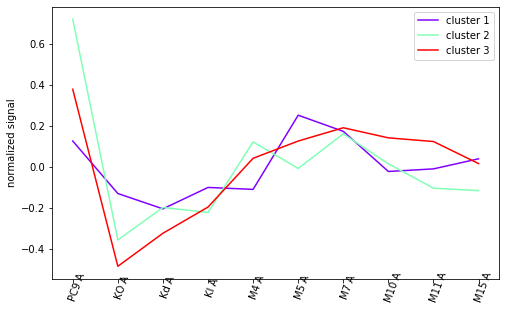

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, mixedCl_plsr, ncl)

In [13]:
ABC

,Protein,Sequence,UniprotAcc,Abbv,Position,BioReps,r2_Std,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A
4,40S ribosomal protein SA,LTEASyVNLPT,P08865,RPSA,Y139-p,1,N/A,-0.905683,-0.264555,0.166887,0.990224,-0.256346,0.239761,-0.126352,0.681401,-0.332600,-0.192736
5,60S ribosomal protein L10a,SRDTLyEAVRE,P62906,RPL10A,Y11-p,1,N/A,0.450394,-0.024163,-0.203233,-0.619397,0.103645,-0.157415,-0.012527,0.406166,0.098905,-0.042375
10,Abl interactor 2,VVPNDyVPSPT,Q9NYB9,ABI2,Y213-p,1,N/A,0.721179,-1.069889,-0.432169,0.246437,0.267770,0.015784,0.185314,0.205212,0.087689,-0.227328
14,Activated CDC42 kinase 1,VKKPTyDPVSE,Q07912,TNK2,Y518-p,1,N/A,1.080712,-0.256996,-0.071764,-0.628678,0.221895,-0.335861,0.014586,0.098401,-0.022027,-0.100268
16,Afadin,TYTREyFTFPA,P55196,AFDN,Y1230-p,1,N/A,1.708259,-0.412595,-0.156932,-0.497972,0.261536,-0.059345,0.208678,0.037391,-0.361757,-0.727262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,Tyrosine-protein phosphatase non-receptor type 11,RKGHEyTNIKY,Q06124,PTPN11,Y546-p,1,N/A,0.859612,-0.262110,-0.060600,-0.839266,0.114222,-0.483345,0.351645,0.171101,0.251626,-0.102885
350,Tyrosine-protein phosphatase non-receptor type 6,GQESEyGNITY,P29350,PTPN6,Y536-p,1,N/A,-0.487781,0.064745,-0.002907,0.089289,-0.107221,0.594054,-0.050929,-0.161403,-0.127804,0.189956
351,Tyrosine-protein phosphatase non-receptor type substrate 1,PSFSEyASVQV,P78324,SIRPA,Y496-p,1,N/A,0.959928,-0.907931,-0.033116,-0.481825,0.436319,-0.163870,0.024939,0.111514,0.109740,-0.055698
353,Uncharacterized protein C6orf132,PGSADyGFAPA,Q5T0Z8,C6orf132,Y1142-p,1,N/A,0.919313,0.008038,-0.628323,-0.065899,-0.067763,0.441085,-0.160495,-0.329553,-0.004565,-0.111838
